In [ ]:
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
100% 866M/866M [00:03<00:00, 240MB/s]
replace PlantVillage/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Import Libraries


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 80

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing background ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Strawberry___Leaf_scorch ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing 

Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/25
78/78 [==============================] - 47s 445ms/step - loss: 0.6380 - accuracy: 0.0529 - val_loss: 0.2224 - val_accuracy: 0.0337
Epoch 2/25
78/78 [==============================] - 33s 428ms/step - loss: 0.2139 - accuracy: 0.1062 - val_loss: 0.2416 - val_accuracy: 0.0481
Epoch 3/25
78/78 [==============================] - 33s 428ms/step - loss: 0.1255 - accuracy: 0.2095 - val_loss: 0.1777 - val_accuracy: 0.0288
Epoch 4/25
78/78 [==============================] - 33s 427ms/step - loss: 0.1031 - accuracy: 0.3205 - val_loss: 0.1585 - val_accuracy: 0.0304
Epoch 5/25
78/78 [==============================] - 33s 428ms/step - loss: 0.0913 - accuracy: 0.3878 - val_loss: 0.1341 - val_accuracy: 0.0657
Epoch 6/25
78/78 [==============================] - 33s 427ms/step - loss: 0.0850 - accuracy: 0.4363 - val_loss: 0.0766 - val_accuracy: 0.4279
Epoch 7/25
78/78 [==============================] - 33s 428ms/step - loss: 0.0768 - accuracy: 0.4704 - val_loss: 0.

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

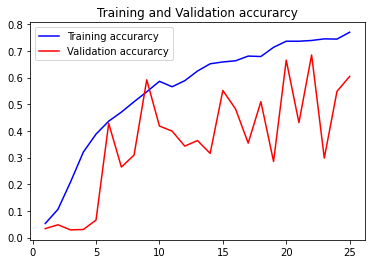

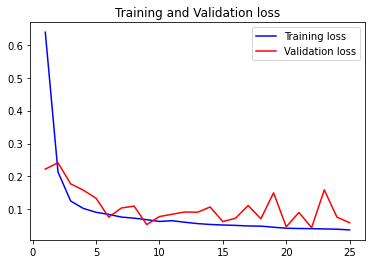

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
20/20 [==============================] - 1s 34ms/step - loss: 0.0597 - accuracy: 0.6042
Test Accuracy: 60.41666865348816


# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://292298f8-96f8-4cbe-8e9c-de6e93e6f471/assets


In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    #print(x_test)
    predict_x=model.predict(np_image) 
    classes_x=np.argmax(predict_x,axis=1)
    #result = model.predict_classes(np_image)
    #print(classes_x)
    print((image_labels.classes_[classes_x][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

Blueberry___healthy


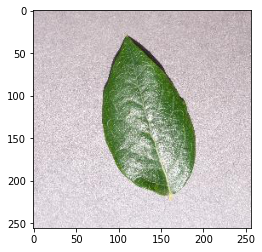

In [ ]:
predict_disease('/content/PlantVillage/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

Potato___Early_blight


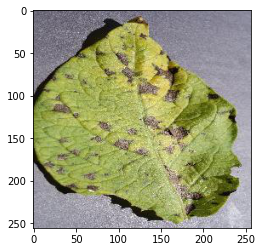

In [ ]:
predict_disease('/content/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

Apple___Apple_scab


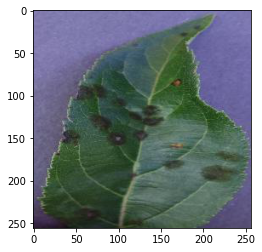

In [ ]:
predict_disease('/content/PlantVillage/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG')

Orange___Haunglongbing_(Citrus_greening)


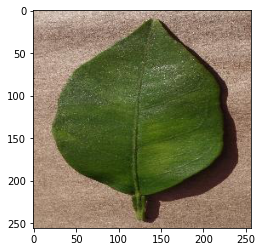

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [ ]:
# Download the trained model file based on its file ID.
file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
!gdown https://drive.google.com/uc?id={file_id}

# Download the labels file based on its file ID.
file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
!gdown https://drive.google.com/uc?id={file_id}

Downloading...
From: https://drive.google.com/uc?id=1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl
To: /content/plant_disease_classification_model.pkl
100% 698M/698M [00:02<00:00, 252MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu
To: /content/plant_disease_label_transform.pkl
100% 8.18k/8.18k [00:00<00:00, 3.91MB/s]


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Load the trained model and its labels for prediction.

In [ ]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    predict_x=model.predict(np_image) 
    classes_x=np.argmax(predict_x,axis=1)
    print(classes_x)
    """result = model.predict(np_image)
    print((image_labels.classes_[classes_x][0]))"""

Predict disease of any plant image.

In [ ]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/028159fc-995e-455a-8d60-6d377580a898___RS_NLB 4023.JPG')